<a href="https://colab.research.google.com/github/Ellen-Gu/jupyter-colab/blob/main/umap_tsne_propensityScore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

UMAP (2020) and t-SNE (2008) stand out as renowned methods for dimensionality reduction. T-SNE takes a probabilistic approach, which many find more intuitive, while UMAP dives into the realm of topology, making it slightly more complex, especially for those not well-versed in this field. Despite their differences, they often yield strikingly similar results when mapping high-dimensional data into a more digestible, low-dimensional space.

My understanding of these methods are that t-SNE might have a slight edge over UMAP when the number of nearest neighbors (k) is less than 20. Conversely, UMAP tends to outperform when k is substantial. A significant advantage of UMAP is its speed; it often processes data much more swiftly than t-SNE. In scenarios involving extensive datasets, exceeding 1 million data points, UMAP can be up to a hundred times faster. Thus, t-SNE may be better suited for smaller and sparser high-dimensional data sets, whereas UMAP shines with larger, denser datasets.

When it comes to visualizing the projected data, both matplotlib and plotly have been put to the test. Plotly emerges as the more efficient tool, boasting faster performance while consuming minimal CPU resources. Additionally, Plotly's interactive web interface enhances user experience by allowing zoom-in features and detailed point examinations, similar to some leading business intelligence tools.

The application of propensity score studies frequently entails grappling with high-dimensional data to identify the most compatible control data. It sparks curiosity whether visualization methodologies like t-SNE and UMAP could be employed to gauge the efficacy of data derived from the propensity score matching process. If the data, when mapped to a lower dimension, exhibits reasonable patterns while the matched data from the propensity study populates major clusters in a coherent manner, it would be indicative of the matching quality's excellence.

I conducted a simulation to examine how the results from the propensity process are distributed among clusters. Using a 1000x25 dataset, we employed various distributions for the data:

* Variables 1-5: Drawn from a Uniform distribution.
* Variables 6-10: Based on a t-distribution with 2 degrees of freedom.
* Variables 11-15: Sourced from a Chi-squared distribution with 5 degrees of freedom.
* Variables 16-20: A combination of two normal distributions.
* Variables 21-25: Binary dummy variables.

Furthermore, uniform noise U(0,10) was introduced to 50% of the rows chosen at random. These rows were then identified with the "UnifNoise" label. When this dataset was projected into 2D, I anticipated two distinct clusters. Treatment labels were also generated, accounting for approximately 5% of the dataset. I then undertook the propensity scoring process to identify matched control data for these treatment labels. The expectation was that these matched pairs would uniformly span both clusters without manifesting any discernible patterns.

The outcome of our simulation aligned with our predictions. Both UMAP and t-SNE project the 25 dimensional data into two clusters in their 2D visualizations, showcasing a remarkable consistency between the two methods. Furthermore, the matched pairs of control and treatment data points were uniformly distributed across both clusters. This is also expected.


In [18]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82808 sha256=7265006080be7b51f5217b8eabdd73d54a392b91b801b2416410b976ef2abee2
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55617 sha256=8d287e179080c8b7c13cf45dbd98bd81f9a312ec6191c2d483eee64e07d89afb
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [46]:
import numpy as np
import pandas as pd

np.random.seed(42)  # for reproducibility

n_samples = 1000

# Variables 1-5: Uniform random
X1_5 = np.random.rand(n_samples, 5)

# Variables 6-10: t-distribution with 2 degrees of freedom
X6_10 = np.random.standard_t(df=2, size=(n_samples, 5))

# Variables 11-15: Chi-squared distribution with 5 degrees of freedom
X11_15 = np.random.chisquare(df=5, size=(n_samples, 5))

# Variables 16-20: Mixture of two normal distributions
mixing_prob = 0.5
mixture = np.random.choice([0, 1], p=[mixing_prob, 1-mixing_prob], size=(n_samples, 5))
X16_20 = np.where(mixture, np.random.normal(0, 1, size=(n_samples, 5)), np.random.normal(3, 1, size=(n_samples, 5)))

# Variables 21-25: Dummy variables
X21_25 = np.random.randint(0, 2, size=(n_samples, 5))

# Combine all variables
X = np.hstack([X1_5, X6_10, X11_15, X16_20, X21_25])

# Assuming the same formula for treatment assignment for simplicity
#treatment = (X[:, 0] + X[:, 1] - X[:, 2] + 0.5*X[:, 3] > 1.5).astype(int)
treatment_array = np.zeros(X.shape[0], dtype=int)
treatment_indices = np.random.choice(np.arange(X.shape[0]), size=int(0.05 * X.shape[0]), replace=False)
treatment_array[treatment_indices] = 1
X=np.hstack((X, treatment_array.reshape(-1, 1)))

data = pd.DataFrame(X, columns=[f'feature{i}' for i in range(1, 26)]+['Treatment'])

#=====================
# 1. Create a binary mask for 30% of the rows
mask = np.random.choice([0, 1], size=n_samples, p=[0.7, 0.3])

# Generate the uniformly distributed random value u(0,10) for these selected rows
random_values = np.array([np.random.uniform(0, 10, 25) if m else np.zeros(25) for m in mask])

# Add the random value to the selected rows for the first 25 columns
data.iloc[:, :25] += random_values

# Add a 'selected' column indicating whether the row was modified
data['UnifNoise'] = mask


In [47]:
data.describe()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,Treatment,UnifNoise
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.013775,1.879181,1.972858,1.881784,1.997030,1.504005,1.351883,1.405499,1.449495,1.184906,...,2.907193,3.015292,2.901426,1.924455,1.880875,2.003720,1.888428,1.876366,0.050000,0.281000
std,2.858360,2.684873,2.824615,2.744810,2.833022,3.715770,3.539302,3.679170,4.237383,4.001232,...,3.314488,3.401559,3.255430,2.762434,2.753258,2.834588,2.783616,2.710568,0.218054,0.449712
min,0.000227,0.000031,0.000012,0.000943,0.005506,-19.344903,-18.158848,-23.607848,-46.793854,-41.734031,...,-3.453354,-2.912160,-2.507826,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.322484,0.328577,0.347270,0.342296,0.340318,-0.537732,-0.556157,-0.462620,-0.381455,-0.589403,...,0.413326,0.462057,0.479898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.691008,0.677713,0.661837,0.675099,0.699780,0.434836,0.455483,0.470032,0.536025,0.355631,...,2.360270,2.587514,2.374670,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,2.017011,1.731524,1.785457,1.171125,2.039084,2.485246,2.528730,2.603032,2.753129,2.231671,...,4.243805,4.232491,4.195196,1.503266,1.505179,1.812121,1.222824,1.879277,0.000000,1.000000
max,10.435733,10.667991,10.836725,10.669783,10.761947,35.042491,18.303719,19.394733,47.972628,18.611378,...,14.018800,14.379435,14.202334,10.943769,10.996495,10.938886,10.902232,10.977125,1.000000,1.000000


In [48]:
from sklearn.linear_model import LogisticRegression

# Calculate propensity scores
lr = LogisticRegression(max_iter=1000)
lr.fit(data.drop(['Treatment', 'UnifNoise'], axis=1), data['Treatment'])
data['Propensity_score'] = lr.predict_proba(data.drop(['Treatment', 'UnifNoise'], axis=1))[:, 1]

# Separate treated and control groups
treated = data[data['Treatment'] == 1].copy()
controls = data[data['Treatment'] == 0].copy()

control_indices = []

# Propensity score matching
for _, row in treated.iterrows():
    if not controls.empty:
        controls['abs_diff'] = np.abs(controls['Propensity_score'] - row['Propensity_score'])
        closest_control_idx = controls['abs_diff'].idxmin()
        control_indices.append(closest_control_idx)
        controls.drop(closest_control_idx, inplace=True)

# Assigning the matched controls in the original data dataframe
data['Control_group'] = 0
data.loc[control_indices, 'Control_group'] = 1

# Printing means of the treated group and matched controls
print("Treated group means:")
print(data[data['Treatment'] == 1].drop(['Treatment', 'Propensity_score', 'Control_group', 'UnifNoise'], axis=1).mean())
print("\nMatched control group means:")
print(data[data['Control_group'] == 1].drop(['Treatment', 'Propensity_score', 'Control_group', 'UnifNoise'], axis=1).mean())



Treated group means:
feature1     2.318588
feature2     1.831686
feature3     2.134495
feature4     1.955796
feature5     2.047693
feature6     1.440189
feature7     1.940839
feature8     2.369001
feature9     1.624383
feature10    1.883990
feature11    7.006402
feature12    6.281774
feature13    6.889921
feature14    7.380700
feature15    6.322358
feature16    3.541116
feature17    3.541474
feature18    3.274114
feature19    3.473902
feature20    3.888464
feature21    1.972714
feature22    2.479636
feature23    2.371325
feature24    1.961544
feature25    1.989787
dtype: float64

Matched control group means:
feature1     2.438316
feature2     2.218187
feature3     2.028804
feature4     2.308397
feature5     2.026640
feature6     1.458418
feature7     1.116102
feature8     2.896450
feature9     1.757268
feature10    1.693449
feature11    7.394489
feature12    6.690904
feature13    6.855413
feature14    8.226560
feature15    5.999534
feature16    4.032543
feature17    3.824664
feature18 

In [49]:
data.describe()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature20,feature21,feature22,feature23,feature24,feature25,Treatment,UnifNoise,Propensity_score,Control_group
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.013775,1.879181,1.972858,1.881784,1.997030,1.504005,1.351883,1.405499,1.449495,1.184906,...,2.901426,1.924455,1.880875,2.003720,1.888428,1.876366,0.050000,0.281000,0.049998,0.050000
std,2.858360,2.684873,2.824615,2.744810,2.833022,3.715770,3.539302,3.679170,4.237383,4.001232,...,3.255430,2.762434,2.753258,2.834588,2.783616,2.710568,0.218054,0.449712,0.039217,0.218054
min,0.000227,0.000031,0.000012,0.000943,0.005506,-19.344903,-18.158848,-23.607848,-46.793854,-41.734031,...,-2.507826,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002332,0.000000
25%,0.322484,0.328577,0.347270,0.342296,0.340318,-0.537732,-0.556157,-0.462620,-0.381455,-0.589403,...,0.479898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027753,0.000000
50%,0.691008,0.677713,0.661837,0.675099,0.699780,0.434836,0.455483,0.470032,0.536025,0.355631,...,2.374670,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.041241,0.000000
75%,2.017011,1.731524,1.785457,1.171125,2.039084,2.485246,2.528730,2.603032,2.753129,2.231671,...,4.195196,1.503266,1.505179,1.812121,1.222824,1.879277,0.000000,1.000000,0.059728,0.000000
max,10.435733,10.667991,10.836725,10.669783,10.761947,35.042491,18.303719,19.394733,47.972628,18.611378,...,14.202334,10.943769,10.996495,10.938886,10.902232,10.977125,1.000000,1.000000,0.444485,1.000000


In [50]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Applying t-SNE
tsne = TSNE(n_components=2, random_state=42)
data_tsne_2d = tsne.fit_transform(data.drop(['Treatment', 'Propensity_score', 'Control_group','UnifNoise'], axis=1))

import umap
import matplotlib.pyplot as plt

# Apply UMAP
reducer = umap.UMAP(random_state=42)
data_umap_2d = reducer.fit_transform(data.drop(['Treatment', 'Propensity_score', 'Control_group','UnifNoise'], axis=1))


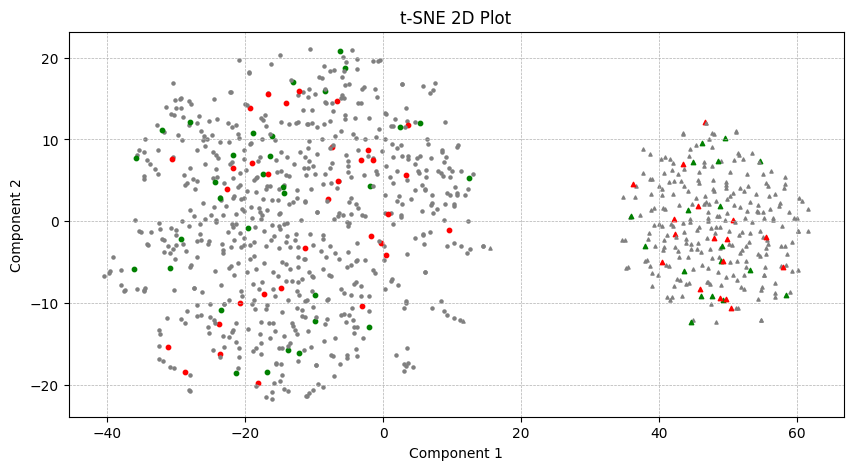

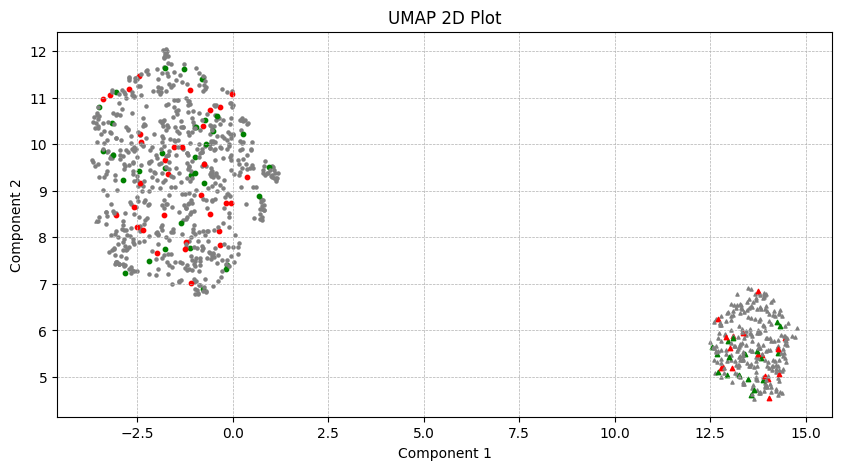

In [51]:
import matplotlib.pyplot as plt

# Extract data for plotting
x_tsne = data_tsne_2d[:, 0]
y_tsne = data_tsne_2d[:, 1]

x_umap = data_umap_2d[:, 0]
y_umap = data_umap_2d[:, 1]

# Define the color and marker styles
colors = ['grey'] * len(data)  # default to grey
markers = ['o'] * len(data)   # default to circle

# Set colors and markers based on the criteria
for idx, row in data.iterrows():
    if row['Control_group'] == 1:
        colors[idx] = 'green'
    elif row['Treatment'] == 1:
        colors[idx] = 'red'

    if row['UnifNoise'] == 1:
        markers[idx] = '^'  # triangle

# Plotting t-SNE
plt.figure(figsize=(10, 5))
for x, y, c, m in zip(x_tsne, y_tsne, colors, markers):
    plt.scatter(x, y, color=c, marker=m, s=10 if c != 'grey' else 5)
plt.title("t-SNE 2D Plot")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Plotting UMAP
plt.figure(figsize=(10, 5))
for x, y, c, m in zip(x_umap, y_umap, colors, markers):
    plt.scatter(x, y, color=c, marker=m, s=10 if c != 'grey' else 5)
plt.title("UMAP 2D Plot")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


In [52]:
import plotly.graph_objects as go

# Custom function for getting colors and symbols based on the criteria
def get_colors_symbols(row):
    color = 'grey'  # default color for all dots
    symbol = 'circle'

    if row['Control_group'] == 1:
        color = 'green'
    elif row['Treatment'] == 1:
        color = 'red'

    if row['UnifNoise'] == 1:
        symbol = 'triangle-up'

    return color, symbol

colors, symbols = zip(*data.apply(get_colors_symbols, axis=1))

# t-SNE 2D plot
fig_tsne_2d = go.Figure()
fig_tsne_2d.add_trace(go.Scatter(x=data_tsne_2d[:, 0], y=data_tsne_2d[:, 1],
                                 mode='markers',
                                 marker=dict(color=colors, symbol=symbols,
                                             #size=[5 if color != 'grey' else 5 for color in colors],
                                             opacity=0.6)))

# Set the background color
fig_tsne_2d.update_layout(plot_bgcolor='whitesmoke',title="t-SNE 2D Plot")
fig_tsne_2d.show()


# UMAP 2D plot
fig_umap_2d = go.Figure()
fig_umap_2d.add_trace(go.Scatter(x=data_umap_2d[:, 0], y=data_umap_2d[:, 1],
                                 mode='markers',
                                 marker=dict(color=colors, symbol=symbols,
                                             #size=[4 if color != 'grey' else 5 for color in colors],
                                             opacity=0.7)))

# Set the background color
fig_umap_2d.update_layout(plot_bgcolor='whitesmoke',title="UMAP 2D Plot")
fig_umap_2d.show()



One intriguing aspect I explored with OpenAI concerned the seemingly indifferent treatment of variable order by both UMAP and t-SNE. To illustrate, let's consider the 'digits' example commonly found in the documentation of both techniques. Each graph here represents an 8x8 matrix where the cell values are either 0 or 1. These matrices are then flattened into rows with 64 columns. When analyzing 1797 such graphs, the input for UMAP and t-SNE becomes a 1797x64 dataframe. Intrinsically, the order of these variables holds significance. While UMAP and t-SNE have exhibited exemplary projections with this data, there's potential for them to overlook patterns under specific scenarios. OpenAI concurred, highlighting that Convolutional Neural Networks (CNN) are better equipped to process grid-like structures.

Subsequently, I initiated a simulation test, introducing AR(1) correlations with a coefficient, $ρ=0.3$, to randomly chosen rows. The data was then segmented into four categories:

* No uniform noise and no AR(1) correlation in columns (color = grey)
* Uniform noise only (color = red)
* AR(1) correlation only (color = green)
* Both uniform noise and AR(1) correlation (color = blue)

The findings indicated that while both UMAP and t-SNE adeptly managed the uniform noise(variable order independent), neither could discern the AR(1) correlation (variable order dependent). This suggests that these methods might have limitations when addressing order-dependent correlation patterns. Plot of the simulation results are as below.


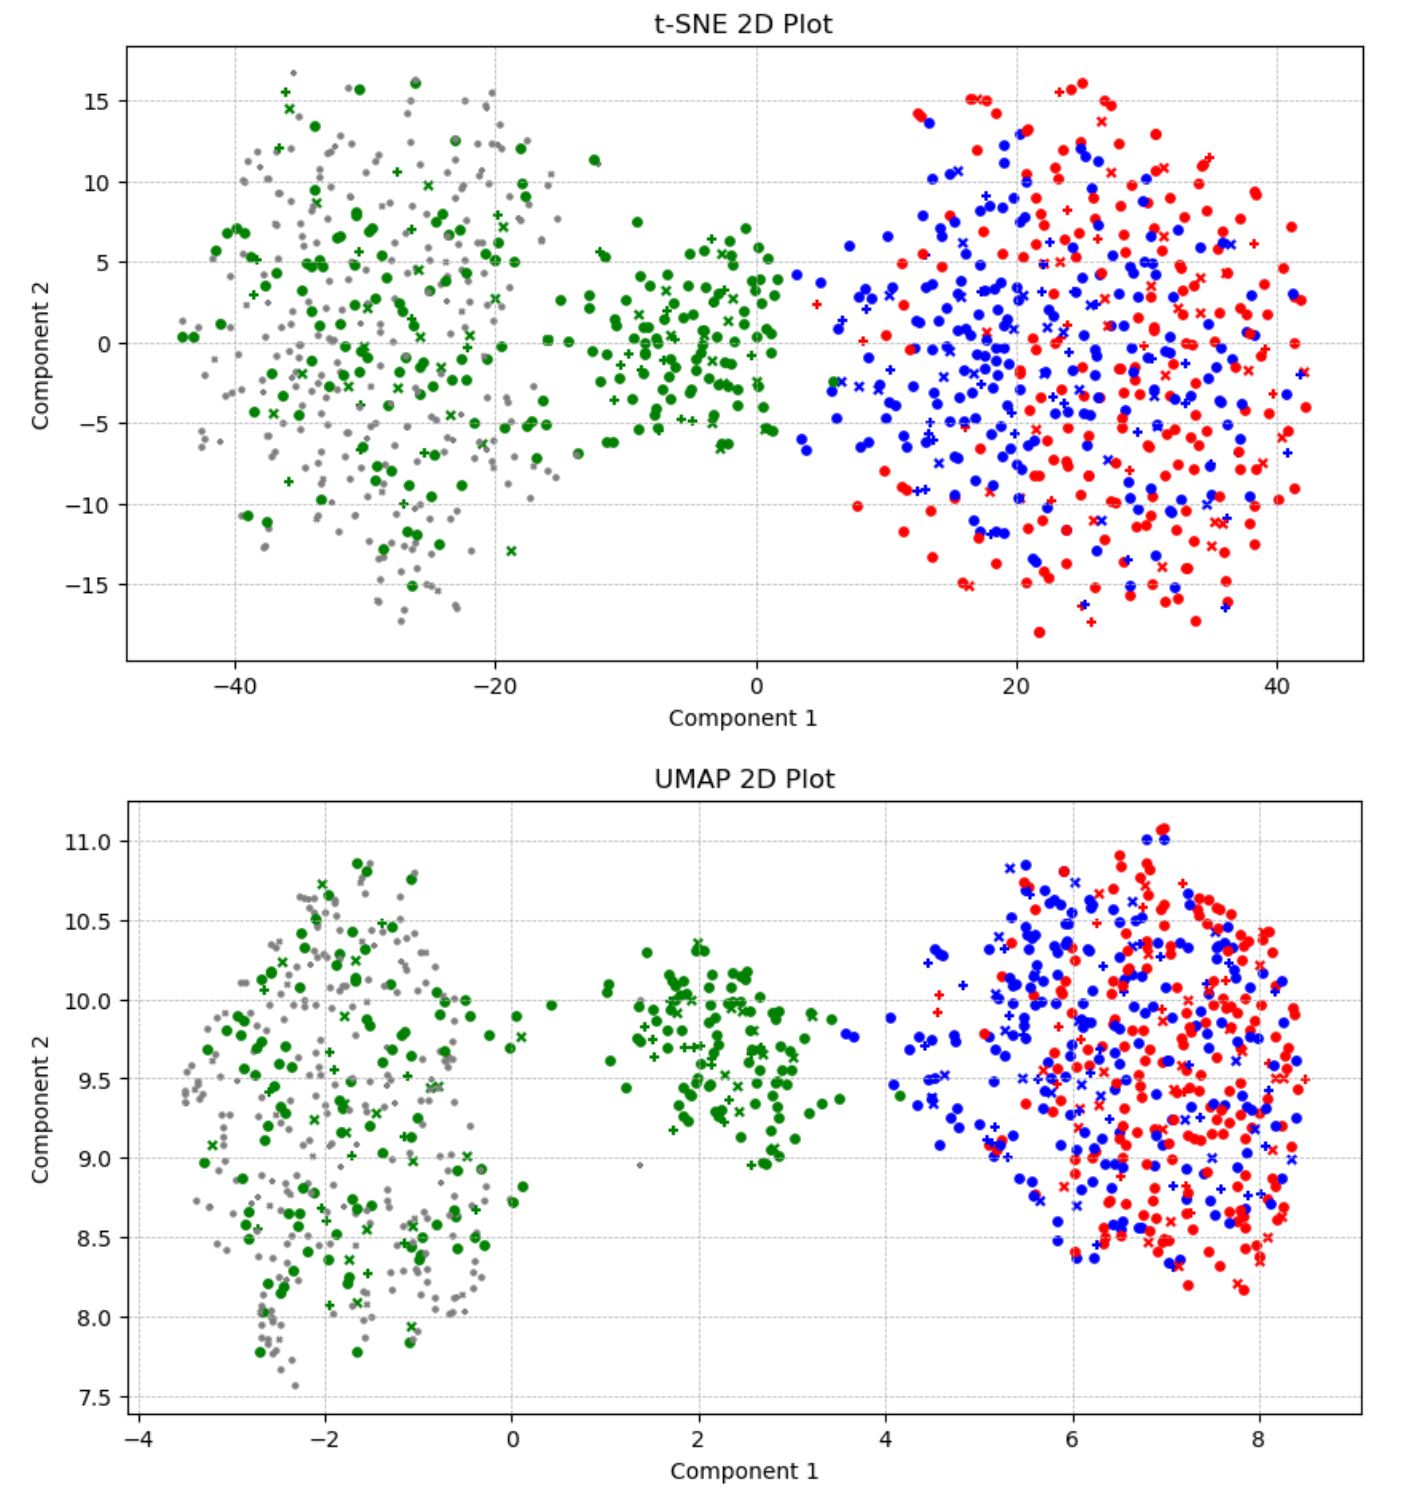

Both UMAP and t-SNE employ Cauchy (t(1)) or similar t(1) distributions as a foundation to gauge similarities in lower dimensions. The rationale behind this is the deployment of a heavy-tailed distribution, which serves to make the entire process either more aggressive or stringent compared to points distributed normally. Within the context of hypothesis testing, a heavy-tailed distribution demands more robust data evidence to reject the null hypothesis, $H_0$. The subsequent plot delineates the density curves of both the Cauchy and standard normal distributions. For a two-tailed test at $\alpha=0.05$, the critical z-value for the standard normal distribution is 1.96, whereas for the Cauchy distribution, it's considerably higher at 12.71. This underscores the strictness imposed by the heavy-tailed distribution when evaluating statistical significance.

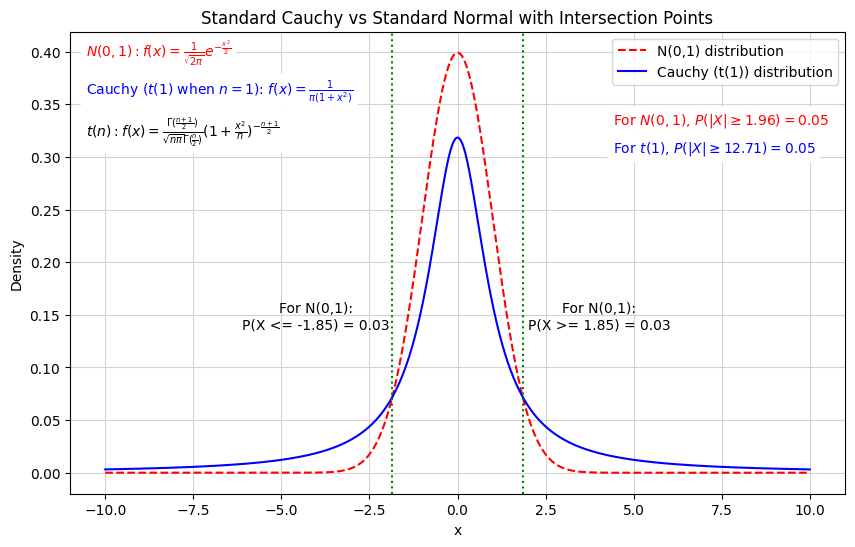

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, norm
from scipy.optimize import fsolve

# Define the range for x values
x = np.linspace(-10, 10, 1000)

# Compute the pdf of t(1) and N(0,1) for each x value
cauchy_pdf_values = t.pdf(x, df=1)
normal_pdf_values = norm.pdf(x, 0, 1)

# Find intersections by setting t(1) pdf equal to N(0,1) pdf
def find_intersection(x):
    return t.pdf(x, df=1) - norm.pdf(x, 0, 1)

x1, x2 = fsolve(find_intersection, [-2, 2])  # initial guesses for the solver
# Calculate the probabilities
prob_x1 = norm.cdf(x1)
prob_x2 = 1 - norm.cdf(x2)

# Calculate x and y values for the properties
x_val = norm.ppf(1 - 0.025)  # as P(|Z| >= x) = 0.05
y_val = t.ppf(1 - 0.025, df=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, normal_pdf_values, label="N(0,1) distribution", color="red", linestyle="--")
plt.plot(x, cauchy_pdf_values, label="Cauchy (t(1)) distribution", color="blue")
plt.axvline(x1, color="green", linestyle=":")
plt.axvline(x2, color="green", linestyle=":")

# Annotations with modified bbox
bbox_props = dict(boxstyle="round", facecolor="white", edgecolor="white")
plt.annotate(r"$N(0,1): f(x) = \frac{1}{\sqrt{2\pi}} e^{-\frac{x^2}{2}}$", (0.02, 0.985), xycoords='axes fraction', color="red", verticalalignment='top', bbox=bbox_props)
plt.annotate(r"Cauchy ($t(1)$ when $n=1$): $f(x) = \frac{1}{\pi(1 + x^2)}$", (0.02, 0.9), xycoords='axes fraction', color="blue", verticalalignment='top', bbox=bbox_props)
plt.annotate(r"$t(n): f(x) = \frac{\Gamma(\frac{n+1}{2})}{\sqrt{n\pi}\Gamma(\frac{n}{2})} (1+\frac{x^2}{n})^{-\frac{n+1}{2}}$", (0.02, 0.82), xycoords='axes fraction', color="black", verticalalignment='top', bbox=bbox_props)
plt.annotate(f'For N(0,1):\nP(X <= {x1:.2f}) = {prob_x1:.2f}', (x1, 0.15), textcoords="offset points", xytext=(-55,-10), ha='center')
plt.annotate(f'For N(0,1):\nP(X >= {x2:.2f}) = {prob_x2:.2f}', (x2, 0.15), textcoords="offset points", xytext=(55,-10), ha='center')
# Legend properties
plt.annotate(f"For $N(0,1)$, $P(|X| \geq {x_val:.2f}) = 0.05$", (0.7, 0.8), xycoords='axes fraction', color="red", bbox=bbox_props)
plt.annotate(f"For $t(1)$, $P(|X| \geq {y_val:.2f}) = 0.05$", (0.7, 0.74), xycoords='axes fraction', color="blue", bbox=bbox_props)

plt.title("Standard Cauchy vs Standard Normal with Intersection Points")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True,color='lightgrey',lw=0.8)
plt.show()


One drawback I found with google colab and micorsoft cloud is that for free usage, there are some time lapse between the results and the successful running of the codes. When working on Azure, I encountered half hour delay from successful running of modified codes and the results updating. Google colab has the similar issue but much less time delay (less than 0.5 min) comparing to Azure when updating the generated data. Sometimes I ran into this delay problem and just can not find any issues. I tried to modify codes then messed up. So when using those free usage account, we may need to be a little bit patient, waiting a while if the calculating is not light enough.

Or, we may build our own running environment and use google colab as the interface. I feel very convenient and enjoy the nice combination of google colab interface and local running environment. However, Google colab only allow http and token style connection to local running environment. If google colab  could consider to allow https, real domain name and password style connection that will be great.